<a href="https://colab.research.google.com/github/taranaalex/MLPNS_ATarana/blob/main/EthicsAIaenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [57]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [59]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [60]:
cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


--2023-05-07 18:29:15--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip [following]
--2023-05-07 18:29:16--  https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip [following]
--2023-05-07 18:29:17--  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 404 Not Found
2023-05-07 18:29:17 ERROR 404: Not Found.



In [ ]:
!unzip faces95.zip

unzip:  cannot find or open faces95.zip, faces95.zip.zip or faces95.zip.ZIP.


In [ ]:
!ls MLPNS2023

model.png  raw.githubusercontent.com  spm  spm-20210427T111354Z-001.zip


In [ ]:
flist = glob.glob("MLPNS2023/faces95/*/*jpg")

In [ ]:
N = len(flist)
N

0


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

In [ ]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

IndexError: ignored

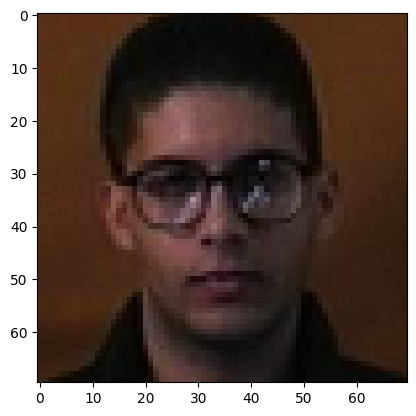

In [ ]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-31-8d7a10a391be>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1140 [00:00<?, ?it/s]

In [ ]:
np.save("data/faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [ ]:
imgs = np.load("data/faces_saved.npy")
imgs.shape

(1140, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [ ]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [ ]:
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2, 
                        int(imgs.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1140, 35, 35)

In [ ]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [ ]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((912, 35, 35), (228, 35, 35), (912, 70, 70, 1), (228, 70, 70, 1))

In [ ]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [ ]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((912, 1225), (228, 1225), (912, 4900), (228, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [61]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1225))
model.add(Dense(128, activation='relu', name="bottleneck"))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(1225*4, activation='sigmoid'))
model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [ ]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
#model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
57/57 [==============================] - 6s 10ms/step - loss: 0.0421 - mae: 0.1618 - acc: 0.0011 - val_loss: 0.0351 - val_mae: 0.1454 - val_acc: 0.0044
Epoch 2/100000
57/57 [==============================] - 0s 6ms/step - loss: 0.0294 - mae: 0.1326 - acc: 0.0033 - val_loss: 0.0242 - val_mae: 0.1190 - val_acc: 0.0000e+00
Epoch 3/100000
57/57 [==============================] - 0s 5ms/step - loss: 0.0224 - mae: 0.1139 - acc: 0.0033 - val_loss: 0.0198 - val_mae: 0.1075 - val_acc: 0.0044
Epoch 4/100000
57/57 [==============================] - 0s 6ms/step - loss: 0.0184 - mae: 0.1018 - acc: 0.0022 - val_loss: 0.0172 - val_mae: 0.0980 - val_acc: 0.0000e+00
Epoch 5/100000
57/57 [==============================] - 0s 5ms/step - loss: 0.0169 - mae: 0.0966 - acc: 0.0033 - val_loss: 0.0168 - val_mae: 0.0974 - val_acc: 0.0000e+00
Epoch 6/100000
57/57 [==============================] - 0s 6ms/step - loss: 0.0155 - mae: 0.0919 - acc: 0.0044 - val_loss: 0.0149 - val_mae: 0.0901 - val_acc

In [ ]:
model.save("data/imgreconstruct_10000.h5")

In [62]:
# READ IN THE SAVED MODEL
!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/imgreconstruct_10000.h5")

--2023-05-08 12:45:41--  http://fbb.space/mltsa/imgreconstruct_10000.h5
Resolving fbb.space (fbb.space)... 107.180.39.232
Connecting to fbb.space (fbb.space)|107.180.39.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80457300 (77M)
Saving to: ‘imgreconstruct_10000.h5.15’

imgreconstruct_1000 100%[===================>]  76.73M  63.5MB/s    in 1.2s    

2023-05-08 12:45:43 (63.5 MB/s) - ‘imgreconstruct_10000.h5.15’ saved [80457300/80457300]



## predict

In [ ]:
outim = model.predict(X_te)
outim

NameError: ignored

In [ ]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


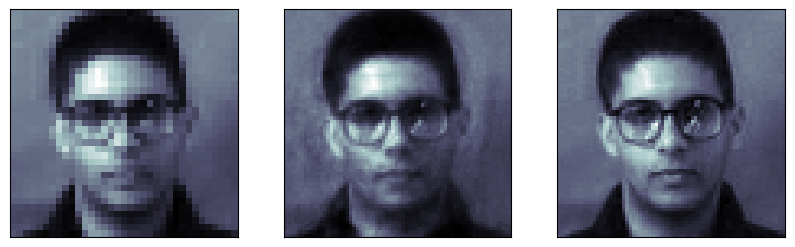

2 :	input		      prediction		  target


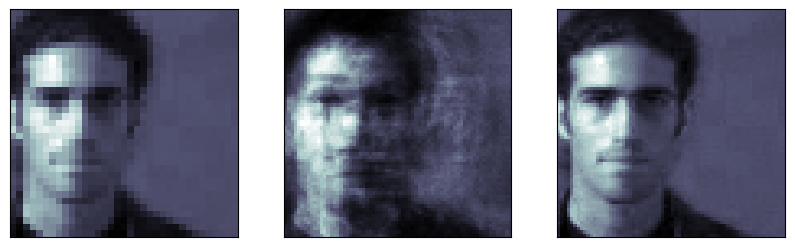

3 :	input		      prediction		  target


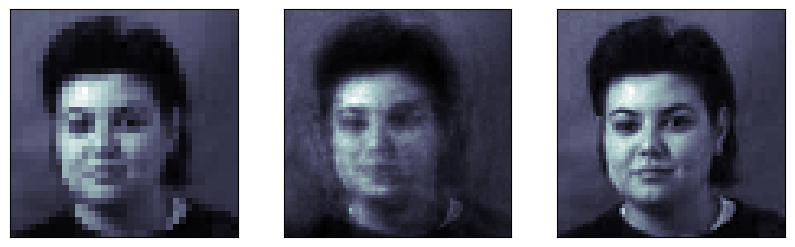

4 :	input		      prediction		  target


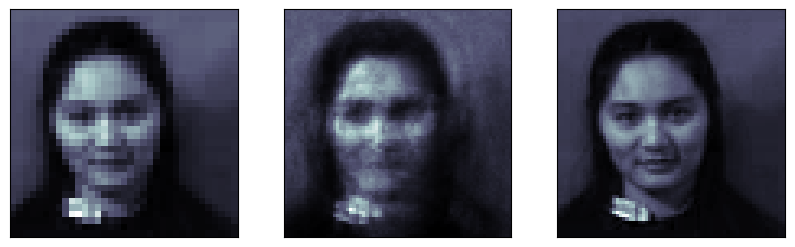

5 :	input		      prediction		  target


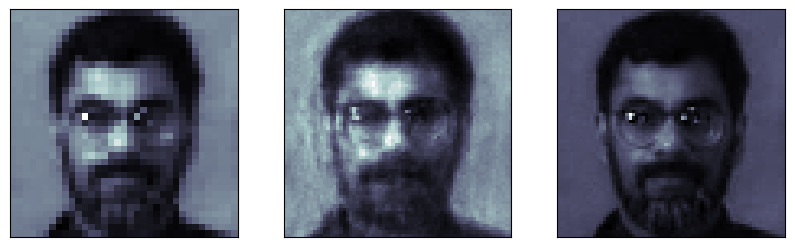

6 :	input		      prediction		  target


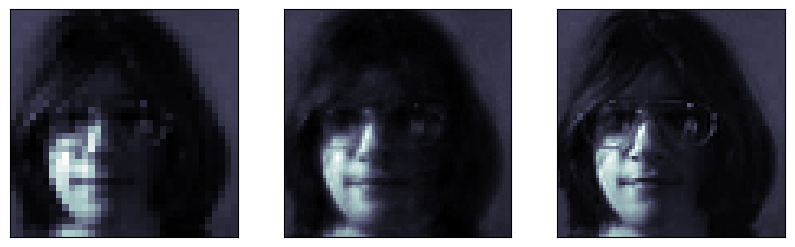

7 :	input		      prediction		  target


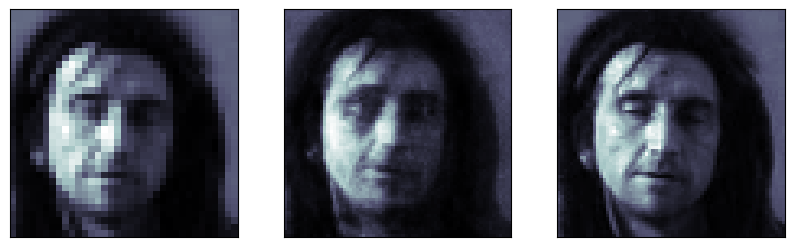

8 :	input		      prediction		  target


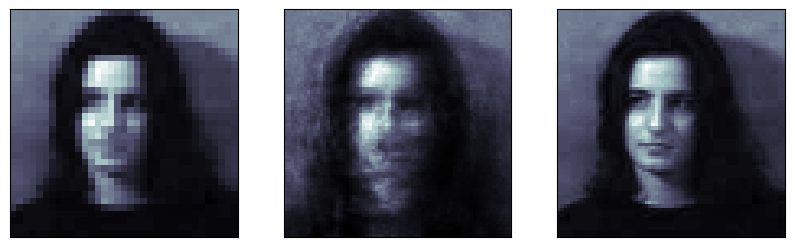

9 :	input		      prediction		  target


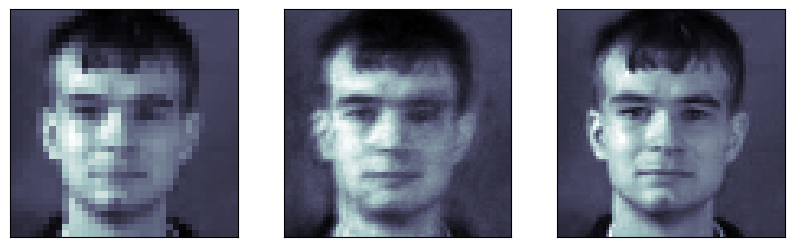

10 :	input		      prediction		  target


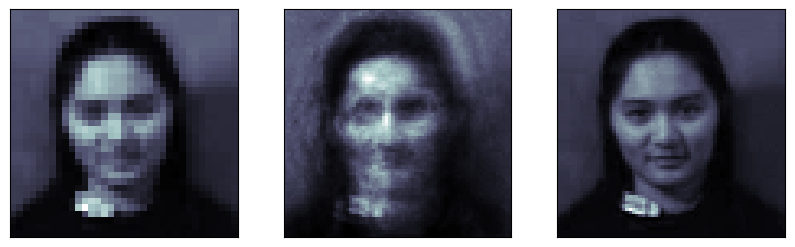

In [ ]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## show the latent representation of the data: the bottleneck layer output

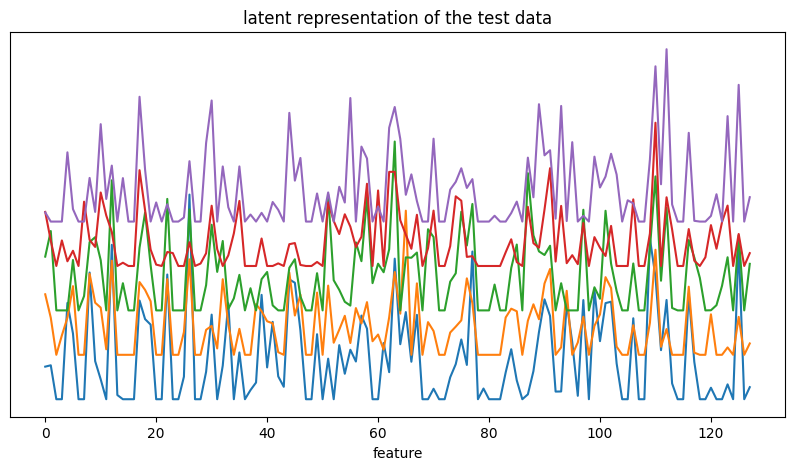

In [ ]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[1].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:5])
  
for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [73]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving miapicResized.jpeg to miapicResized (1).jpeg


In [74]:
file_contents = uploaded[list(uploaded.keys())[0]]

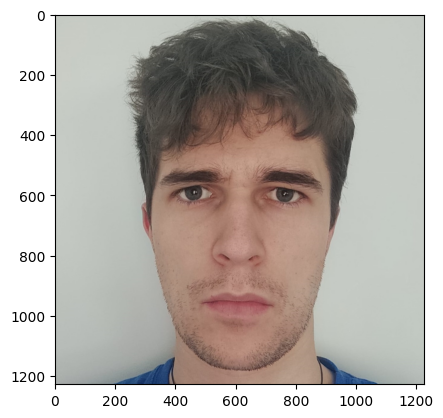

In [75]:
imme = Image.open(BytesIO(file_contents))
pl.imshow(imme)

In [76]:
np.shape(imme)

(1228, 1228, 3)

In [77]:
# Rescales an image
def rescale(img, h, l):
  '''
  input: img (jpeg), h (int), l (int)
  returns: a numpy array h x l (image rescaled)
  '''
  rh = np.shape(img)[0] % h # height reminder
  lh = np.shape(img)[1] % l # lenght reminder
  return np.array(img)[rh::int((np.shape(img)[0]-rh)/h),
                       lh::int((np.shape(img)[1]-lh)/l)].astype(float) / 255

In [78]:
np_im_me = rescale(imme, 35, 35)
np_im_me.shape

(35, 35, 3)

In [79]:
# We want to consider only the first of the three values (RGB) in the following:
np_im_me = np_im_me[:,:,1]

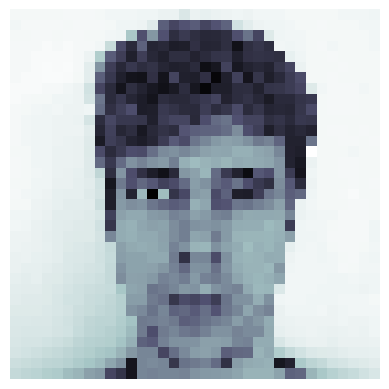

In [80]:

pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 [==============================] - 0s 19ms/step


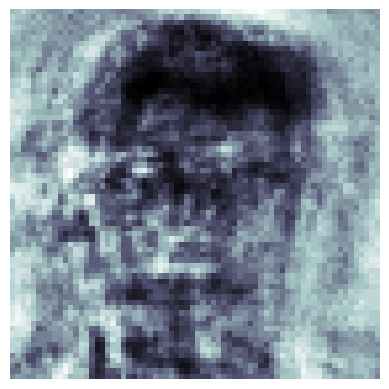

In [81]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??